# Vehicle Detection 

In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import glob
from skimage.feature import hog
from scipy.ndimage.measurements import label
import time

In [2]:
all_vehicle = []
all_vehicle = glob.glob('./training_data/vehicles/GTI_Far/image*.PNG')
all_vehicle.extend(glob.glob('./training_data/vehicles/GTI_MiddleClose/image*.png'))
all_vehicle.extend(glob.glob('./training_data/vehicles/GTI_Right/image*.png'))
all_vehicle.extend(glob.glob('./training_data/vehicles/KITTI_extracted/image*.png'))
all_vehicle.extend(glob.glob('./training_data/side/*.jpg'))
cus_veh = []
cus_veh.extend(glob.glob('./training_data/whiteCar/*.png'))
cus_veh.extend(glob.glob('./training_data/blackCar/*.png'))

# non vehicles 
all_non_vehicles = glob.glob('./training_data/non-vehicles/Extras/extra*.PNG')
all_non_vehicles.extend(glob.glob('./training_data/non-vehicles/GTI/image*.png'))
all_non_vehicles.extend(glob.glob('./training_data/non_veh/*.png'))
line_img = glob.glob('./training_data/temp/*.png')

## Method

#### Data Augmentation 
To increase the size of the data set all the original provided images are trimed and then resized to the original size as shown in figure(1).

Figure(1):
<img src = "https://github.com/vacous/Udacity-SelfDriving/blob/master/Project05-VehicleDetection/ReportImage/subSample.PNG?raw=true" width = "400">

In [3]:
def dupImage(ori_img_array, shrink_factor):
    '''
    use a close size sub image and resized to original size 
    '''
    out_array = ori_img_array.copy()
    for each_img in ori_img_array:
        ori_shape = each_img.shape[:2]
        # cetner
        sub_img_center = each_img[np.int(ori_shape[0] * (1-shrink_factor)):np.int(ori_shape[0] * shrink_factor),
                 np.int(ori_shape[1] * (1-shrink_factor)):np.int(ori_shape[1] * shrink_factor)]
        resized_center  = cv2.resize(sub_img_center, ori_shape)
        # top
        sub_img_top = each_img[0:np.int(ori_shape[0] * shrink_factor),
                 0:np.int(ori_shape[1] * shrink_factor)]
        resized_top  = cv2.resize(sub_img_top, ori_shape)
        # bottom
        sub_img_bottom = each_img[np.int(ori_shape[0] * (1-shrink_factor)):np.int(ori_shape[0]),
                 np.int(ori_shape[1] * (1-shrink_factor)):np.int(ori_shape[1])]
        resized_bottom  = cv2.resize(sub_img_bottom, ori_shape) 
        out_array.append(resized_center)
        out_array.append(resized_top)
        out_array.append(resized_bottom)
    return out_array

#### Feature Selection
The color distribution and the histrogram of oriented gradient features are used as the features. To emphasize the importance of the shape, in the color distribution, canny edge detection is applied to the original image, and then the pixle value distribution of the processed image is also used in addtional to the distributions of 3 color channels Y Cr and Cb. 
Since Color should not affect the result in the case of shapes, for the hog features, gray image is used. 

Figure(2): Example of Color Distribution 

<img src = "https://d17h27t6h515a5.cloudfront.net/topher/2017/March/58bfb1ca_hist-compare/hist-compare.jpg" width = "400">

Figure(3): Example of Canny Edged Image 

<img src = "https://github.com/vacous/Udacity-SelfDriving/blob/master/Project05-VehicleDetection/ReportImage/Canny.png?raw=true" width = "400">

Figure(4): Example of Hog Features 

<img src = "https://d17h27t6h515a5.cloudfront.net/topher/2016/December/585c12d2_car-and-hog/car-and-hog.jpg" width = "400">

In [6]:
def color_hist(in_img, nbins= 64, bins_range=(0, 256)):
    # Compute the histogram of the 3 channels separately
    cvt_img = cv2.cvtColor(in_img, cv2.COLOR_RGB2YCrCb)
    img = cv2.resize(in_img, (64,64))
    # Canny Detection
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    canny_img = cv2.Canny(gray_img, 10, 30 )
    canny_hist = np.histogram(canny_img, bins=nbins, range=bins_range)
    hist_1 = np.histogram(cvt_img[:,:,0], bins=np.int(nbins/4), range=bins_range)
    hist_2 = np.histogram(cvt_img[:,:,1], bins=np.int(nbins/4), range=bins_range)
    hist_3 = np.histogram(cvt_img[:,:,2], bins=np.int(nbins/4), range=bins_range)
    return np.concatenate((canny_hist[0],hist_1[0],hist_2[0],hist_3[0]))

def get_hog_features(in_img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):     
    img = cv2.resize(in_img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=False, feature_vector=feature_vec)
    return features

####  Feature Normalization
The range and the mean of the color distribution features and hog features are very different. The large difference can result in convergence issue in the model training process. To solve this problem, normalization to all features are applied:

pivot = mean(features)

after_norm = (features - pivot)/pivot - 1 


In [68]:
def calMean(array1):
    '''
    calculate the mean for all values in a array
    '''
    count = 0
    sum_val = 0
    for each in array1:
        count += 1
        sum_val += np.mean(each)
    return sum_val/count

def normalizeFeatures(array1, pivot):
    '''
    normlize_array 
    mutate the original dict 
    '''
    for idx in range(len(array1)):
        each = array1[idx]
        array1[idx] = (each - pivot)/pivot - 1 
    return array1

#### Extract Features 

In [69]:
def extractCombineFeatures(all_images, if_veh = True, in_pivots = {}):
    color_features = []
    hog_features = []
    for idx in range(len(all_images)): 
        cur_img = all_images[idx]
        color_features.append(color_hist(cur_img, nbins=64, bins_range=(0, 256)))
        hog_features.append(get_hog_features(cur_img,6, 8, 2))  
    # combine features 
    if len(in_pivots) == 0:
        color_mean = calMean(color_features) 
        hog_mean = calMean(hog_features)
        pivots = {"hog": hog_mean, "color": color_mean} # 
    else:
        color_mean = in_pivots['color']
        hog_mean = in_pivots['hog']
        pivots = in_pivots
    color_features = normalizeFeatures(color_features, color_mean)
    hog_features = normalizeFeatures(hog_features, hog_mean)
    combined_features = [np.concatenate((hog_features[idx], color_features[idx])) for idx in range(len(all_images))]
    if if_veh:
        y_val = np.ones(len(all_images))
    else:
        y_val = np.zeros(len(all_images))
    return y_val, combined_features, pivots


# Prepare Data 
# Veh
cus_veh_imgs = [cv2.resize(cv2.imread(each_address), (64,64)) for each_address in cus_veh]
all_veh_imgs = [cv2.resize(cv2.imread(each_address), (64,64)) for each_address in all_vehicle]
all_veh_imgs.extend(cus_veh_imgs)
for ratio in [0.01 * value + 0.7 for value in range(80)]:
    cur_imgs = dupImage(cus_veh_imgs, ratio)
    all_veh_imgs.extend(cur_imgs)
    
# Non Veh
all_non_veh_imgs = [cv2.imread(each_address) for each_address in all_non_vehicles]
all_veh_imgs = shuffle(all_veh_imgs)
all_non_vehicles = shuffle(all_non_vehicles)
all_line_img = [cv2.imread(each_address) for each_address in line_img]
all_non_veh_imgs.extend(all_line_img)
for ratio in [0.05* value + 0.7 for value in range(20)]:
    all_non_veh_imgs.extend(dupImage(all_line_img, ratio))

# Extract Features 
all_y, all_x, PIVOTS = extractCombineFeatures(all_veh_imgs, if_veh= True)
y_no_veh, x_no_veh, _ = extractCombineFeatures(all_non_veh_imgs, if_veh=False, in_pivots = PIVOTS)

all_x.extend(x_no_veh)
all_y = np.concatenate((all_y,y_no_veh))
all_x, all_y = shuffle(all_x, all_y)
# split into training and test data set 
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size = 0.2, random_state = 40)
print("Number of features:" + str(all_x[0].shape[0]))

Number of features:328


#### Train Model 

In [10]:
# train and test the model 
test_model = svm.SVC()
test_model.fit(x_train, y_train)

# test the model 
pred = test_model.predict(x_test)
acc = accuracy_score(pred, y_test)

print("The test accuracy: " + str(acc))

The test accuracy: 0.99914615771


#### Image Meshing and Window Search
The trained model can only detect image of size 64x64. However, in the actual image, the sub image that contains the vehicle can have different size than 64x64 at any posistion at a random position. To find the position, the original image is meshed into small sub windows, as shown in figure(5). 

Figure(5): Image Meshing 

<img src = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/58a8b3a1_hog-sub/hog-sub.jpg" width = "400">

The trained model is used to check each window and determine if it is a vehicle image.
The checking process can be very time consuming as the number of windows increase. In order to improve the efficiency, only the possible area, bottom half of the image, is meshed and checked. For different regions, the mesh size is selected according to the possible size of the sub image that contains vehicle, as shwon in figure(6).

Figure(6): Mesh sizes for different regions

<img src = "https://github.com/vacous/Udacity-SelfDriving/blob/master/Project05-VehicleDetection/ReportImage/MeshLevel.jpg?raw=true" width = "600">

In [41]:
def multiSearchWindows(in_img, x_range, y_range, mesh_num, levels, steps = [1,1]):
    '''
    x_range = (x1,x2) 
    y_range = (y1,y2)
    mesh_num = (x_mesh, y_mesh)
    '''
    x_bound = in_img.shape[1]
    y_bound = in_img.shape[0]
    x_range[1] = min(x_bound, x_range[1])
    y_range[1] = min(y_bound, y_range[1])
    x_incr = int(np.ceil((x_range[1] - x_range[0])/mesh_num[0]))
    y_incr = int(np.ceil((y_range[1] - y_range[0])/mesh_num[1]))
    all_grid = []
    # create all meshed points 
    for idx in list(range(x_range[0], x_range[1], x_incr)) + [x_range[1]]:
        each_i = []
        for jdx in list(range(y_range[0], y_range[1], y_incr)) + [y_range[1]]:
            each_i.append((idx,jdx))
        all_grid.append(each_i)
    out_windows = []
    # add each mesh window 
    for each_level in levels:
        for idx in list(range(0, len(all_grid) - each_level, steps[0])) + [len(all_grid) - each_level - 1]:
            for jdx in list(range(0, len(all_grid[0]) - each_level, steps[1])) + [len(all_grid[0]) - each_level - 1]:
                top_corner = all_grid[idx][jdx]
                bottom_corner = all_grid[idx + each_level][jdx + each_level]
                out_windows.append((top_corner, bottom_corner))
    return out_windows

def search_windows(img, windows, clf, in_pivot= PIVOTS):
    #Create an empty list to receive positive detection windows
    on_windows = []
    #Iterate over all windows in the list
    for window in windows:
        #Extract the test window from original image
        if ((window[1][1] - window[0][1]) * (window[1][0] - window[0][0])) > 0:
            cur_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            #Extract features for that window using single_img_features()
            _ , cur_features, _= extractCombineFeatures([cur_img], in_pivots= in_pivot)
            #Predict using your classifier
            prediction = clf.predict(cur_features)
            if prediction == 1:
                on_windows.append(window)
    return on_windows


def multiSearch(in_img, svm_model):
    x_range = [750,1280]
    out_result = []
    # Fine Level
    windows = multiSearchWindows(in_img,
                                 [x_range[0], x_range[1]],
                                 [400, 500],
                                 [40,10], levels = range(5, 8, 2), steps= (3,3))
    find_windows = search_windows(in_img, windows, svm_model)
    out_result.extend(find_windows)
    # Medium Level
    windows = multiSearchWindows(in_img,
                                 [x_range[0], x_range[1]],
                                 [400, 600],
                                 [35,13], levels = range(5, 6, 1), steps= (3,3))
    find_windows = search_windows(in_img, windows, svm_model)
    out_result.extend(find_windows)
    # Rough Level
    windows = multiSearchWindows(in_img,
                                 [x_range[0], x_range[1]],
                                 [400, 650],
                                 [25,15], levels = range(10, 13, 3),steps=(7,7))
    find_windows = search_windows(in_img, windows, svm_model)
    out_result.extend(find_windows)
    return out_result

#### Heat Map
As the cases of false positive can appear in the detection, to avoid marking those false positive detections. A heat map, as shown in figure(7), is constructed. 

Figure(7): heat map example 

<img src = "https://d17h27t6h515a5.cloudfront.net/topher/2017/January/588eaef6_screen-shot-2017-01-29-at-7.11.18-pm/screen-shot-2017-01-29-at-7.11.18-pm.png" width = "400">

When a sub window is recogonized as vehicle, in the region of the checked window, the average dot number in a canny edge image of that area is added to all pixles in that window area. Adding the number of dots of canny edge image can largly reduce the chance of marking false positive windows, as the edge will not appear on the road or sky or shade in most of the cases. 
After the heat map is created after going through all windows. The area with a high quantile are marked with a box to show the position of the vehicle.
To futher reduce the false positive marked in the image, weighted 2 frame buffer is used to average the result to elminate the false positive that appear only in a single frame.


In [70]:
def add_heat(canny_img, heatmap, bbox_list, radius = [10,10]):
    # Iterate through list of bboxes
    for box in bbox_list:
#         Add += avg number of canny dots for all pixels inside each bbox
#         Assuming each "box" takes the form ((x1, y1), (x2, y2))
        x_range = [box[0][0], box[1][0]]
        y_range = [box[0][1], box[1][1]]
        canny_dots = calCannyMean(canny_img, x_range, y_range)
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += canny_dots
#    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 7)
    # Return the image
    return img


def calCannyMean(value_img, x_range, y_range):
    total = 0
    count = 0
    for idx in range(x_range[0], x_range[1]):
        for jdx in range(y_range[0], y_range[1]):
            count += 1
            if value_img[jdx, idx] != 0:
                total += value_img[jdx, idx]
    if count == 0:
        return 0
    return total/count


def calQuantile(array1, bar):
    all_val = []
    for each_col in array1:
        for each_val in each_col:
            if each_val != 0:
                all_val.append(each_val)
    if len(all_val) < 1000:
        return 5
    elif len(all_val) != 0:
        return np.percentile(all_val,bar) + 10
    return 0

# Result

#### Model Testing

In [43]:
PRE_HEAT_1 = np.zeros((720,1280))
PRE_HEAT_2 = np.zeros((720,1280))
# pipeline function 
def findCar(in_img, svm_model = test_model, if_plot = False):
    global PRE_HEAT_1, PRE_HEAT_2, PRE_HEAT_3, PRE_HEAT_4
    ini_time = time.time()
    cv_img = cv2.cvtColor(in_img, cv2.COLOR_RGB2BGR)
    S_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2HSV)[:,:,1]
    canny_img = cv2.Canny(S_img, 200, 700)
    find_result = multiSearch(cv_img, svm_model = svm_model)
    heat = np.zeros_like(cv_img[:,:,0]).astype(np.float)
    heat = add_heat(canny_img, heat, find_result)
    heat = (3 * heat + 2 * PRE_HEAT_1 + 1 * PRE_HEAT_2)/6
    if if_plot:
        heat_plot = np.copy(heat)
    (PRE_HEAT_1, PRE_HEAT_2) = (heat, PRE_HEAT_1)
    heat = apply_threshold(heat, threshold= calQuantile(heat, 40))
    heat = cv2.GaussianBlur(heat, (21,21), 0)
    labels = label(heat)
    result_img = draw_labeled_bboxes(in_img, labels)
    render_time = time.time() - ini_time
    render_string = "Frame Render Time: " + ("%.2f" % render_time) + 's'
    out_img= cv2.putText(result_img, render_string, (50, 100) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    if if_plot:
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(heat)
        plt.subplot(1,2,2)
        plt.imshow(out_img)
        plt.show()
    return out_img

C:\Application\MiniConda\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


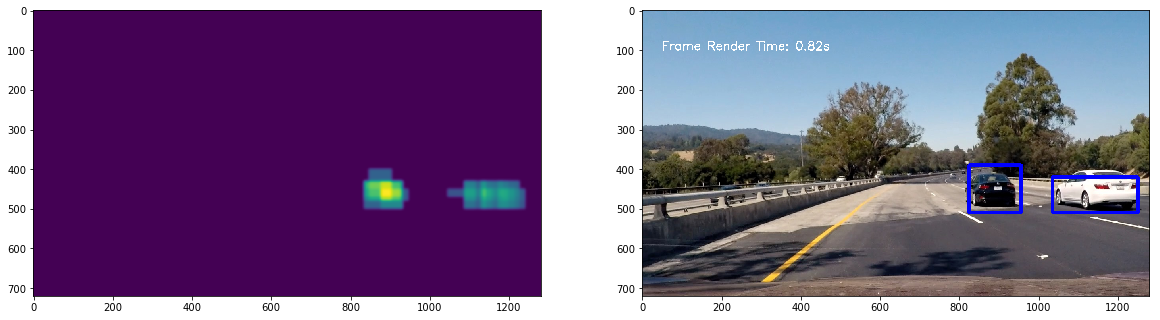

Process Time:  1.2266056537628174


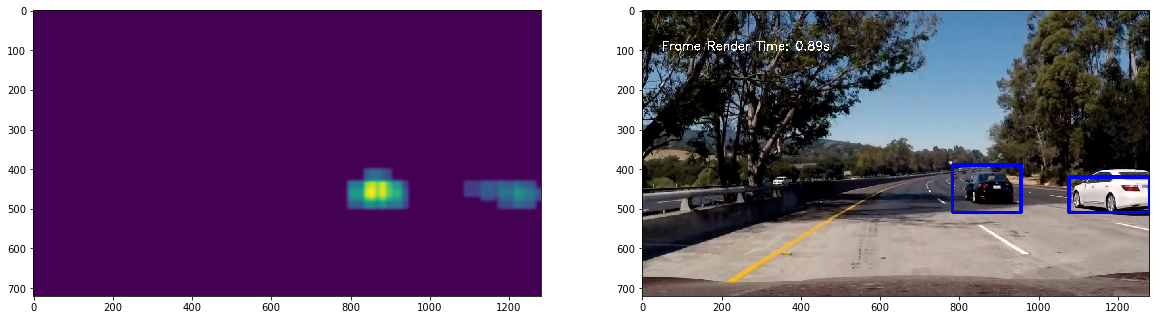

Process Time:  1.2913780212402344


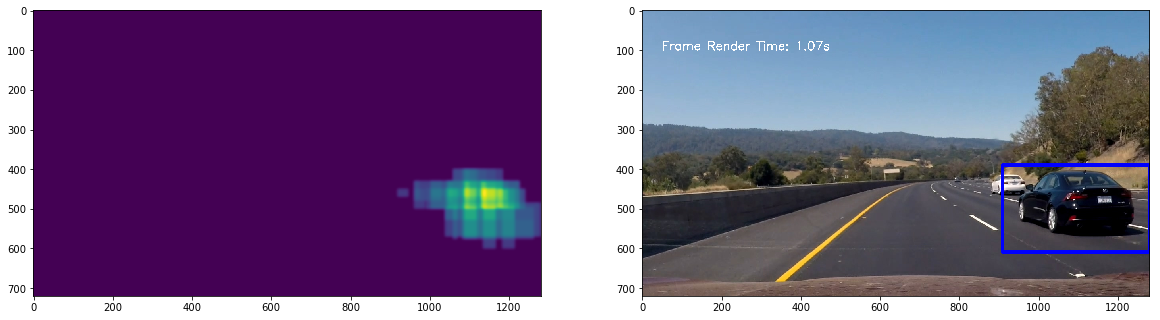

Process Time:  1.534980058670044


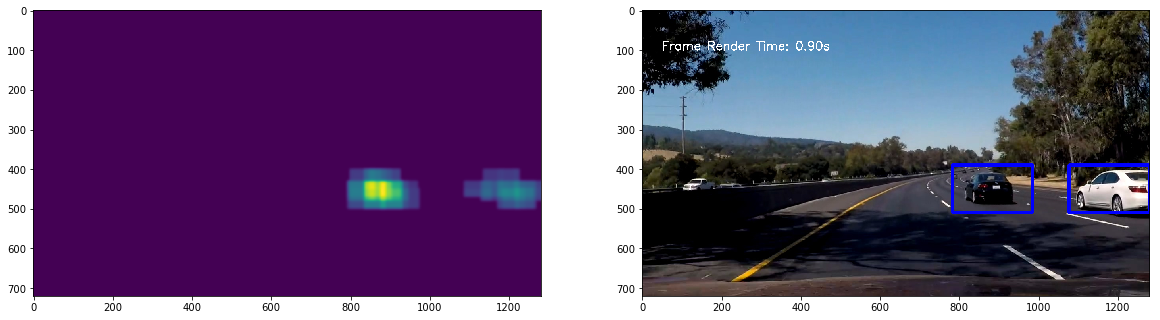

Process Time:  1.299198865890503


In [45]:
for idx in range(4):
    test_img = mpimg.imread('./test_images/test'+ str(idx+1) + '.jpg')
    ini_time = time.time()
    result_img = findCar(test_img, if_plot= True)
    print('Process Time: ', time.time() - ini_time)
    PRE_HEAT_1 = np.zeros((720,1280))
    PRE_HEAT_2 = np.zeros((720,1280))

In [46]:
from moviepy.editor import VideoFileClip
# video 01
white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(findCar)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:51<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



The result video is available in (click the image to view)
[<img src = "https://www.youtube.com/upload_thumbnail?v=LrBTMhXXkfA&t=hqdefault&ts=1496157752392" width = "400">](https://youtu.be/LrBTMhXXkfA)
As shwon, the vehicle in the video are marked correctly. However, the tighness of the bound box is not very stable and rendering takes a significant amount of time. 
To futher improve the efficiency and tighness of the bound boxes, the mesh could use the lane width as the reference value and creating some meshing as shown in figure(7). With this approach, the overlaped area for different meshing size can be eliminated and the meshing parameters can be adjusted automatically by the lane width. 

figure(8): adaptive meshing 

<img src = "https://github.com/vacous/Udacity-SelfDriving/blob/master/Project05-VehicleDetection/ReportImage/MeshLevel2.jpg?raw=true" width = "600">